**In this notebook, the SISALv3 dataset is explored by conducting diverse spatio-temporal analysis.**

In [1]:
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
sns.set_theme(style="darkgrid")
plt.close("all") 

### Load SISAL csv files 

In [2]:
# read all sisalv3.csv files
os.chdir("../data/sisalv3_csv")

entity_df = pd.read_csv('entity.csv')
d18O_df   = pd.read_csv("d18O.csv")
dating_df = pd.read_csv("dating.csv")

# d13C = pd.read_csv("d13C.csv")
# MgCa = pd.read_csv("Mg_Ca.csv")

# some columns of the database have a number on the first position of their name which would produce errors in python
dating_df.rename(columns = {'238U_content':'c238U_content','238U_uncertainty':'c238U_uncertainty',
    '232Th_content':'c232Th_content','c232Th_uncertainty':'c232Th_uncertainty',
    '230Th_content':'c230Th_content','c230Th_uncertainty':'c230Th_uncertainty',
    '230Th_232Th_ratio':'a230Th_232Th_ratio','230Th_232Th_ratio_uncertainty':'a230Th_232Th_ratio_uncertainty',
    '230Th_238U_activity':'a230Th_238U_activity','230Th_238U_activity_uncertainty':'a230Th_238U_activity_uncertainty',
    '234U_238U_activity':'a234U_238U_activity','234U_238U_activity_uncertainty':'a234U_238U_activity_uncertainty'},
    inplace = True)

entity_link_reference_df = pd.read_csv("entity_link_reference.csv")
original_chronology_df   = pd.read_csv("original_chronology.csv")
reference_df             = pd.read_csv("reference.csv")
sample_df                = pd.read_csv("sample.csv")
sisal_chronology_df      = pd.read_csv("sisal_chronology.csv")
site_df                  = pd.read_csv("site.csv")
os.chdir('../../notebooks')

### Temporal average of d18Oc

Inspired from the script sisal3_extractCSVdata.py provided by Jens Fohlmeister in sisalv3 dataset [(which can be dowloaded here)](https://ora.ox.ac.uk/objects/uuid:1e91e2ac-ca9f-46e5-85f3-8d82d4d3cfd4)

Define time range of interest to truncate the data. 

In [3]:
# Extract required data from speleothems covering the period of interest
#   + provides all entities, which include non-14C ages and non-events  
#     during the time period

low = 0         # defines minimum age [a]
high = 500000    # defines maximum age [a] # 500'000 = U/Th datation limit, 50'000 = C14 limit

# Corrected age = corr_age = adjusted for detrital contamination
# Corrected calibrated age = c14 date_type = adjusted for dead carbon
dating_trunc = dating_df.loc[(dating_df['corr_age'] >= low) 
                         &(dating_df['corr_age'] <= high) 
                         &(dating_df['date_type'].str.find('Event')!=0)
                         ] # (dating['date_type']!='C14') &  ## Jens excluded C14 dates but for now i do not see why i should exclude them
print(f'number of samples with C14 dates is {len(dating_trunc.loc[dating_df['date_type']!='C14'])/len(dating_trunc)}')

entities_array = dating_trunc['entity_id'].to_numpy()
entities = np.unique(entities_array) 

# Remove all entities with less than 'n' dated depths
n = 3
j=0
for i in np.arange(0,len(entities)):
    entity_count = dating_trunc.entity_id[dating_trunc.entity_id==entities[i]].count()
    if entity_count < n:
        j=j+1
        dating_trunc = dating_trunc[dating_trunc.entity_id!=entities[i]].copy()
print(f'{j} entities were removed (not enough dated depths)')

entities_array = dating_trunc['entity_id'].to_numpy()
entities = np.unique(entities_array)  # provides all entities, which include >= 'n' dated depths during the required time period


number of samples with C14 dates is 0.9821724382740395
35 entities were removed (not enough dated depths)


In [4]:
### define parameters (all of those will be saved in a final file)
N = len(entities)
site_id     = np.zeros(N)
site_name   = ['0']*N
rock_age    = ['0']*N
material    = ['0']*N
entity_name = ['0']*N
lon         = np.zeros(N)
lat         = np.zeros(N)
entity_id   = np.zeros(N)
mean_O      = np.zeros(N)
std_O       = np.zeros(N)
# mean_C      = np.zeros(N)
# mean_GR     = np.zeros(N)
# mean_MgCa   = np.zeros(N)
# std_C       = np.zeros(N)
# std_GR      = np.zeros(N)
# std_MgCa    = np.zeros(N)

print('number of entities : ',N)
for n in np.arange(0,N):
    plt.close("all")    # close all open figures  

    this_entity = dating_df.loc[(dating_df['entity_id'] == entities[n])]
    #######################################################################

    ### already some metadata for individual speleothems
    site_id[n]     = entity_df.site_id[(entity_df['entity_id'] == entities[n])].to_numpy()
    entity_id[n]   = entity_df.entity_id[(entity_df['entity_id'] == entities[n])].to_numpy()
    entity_name[n] = entity_df.entity_name[(entity_df['entity_id'] == entities[n])].to_list()
    site_name[n]   = site_df.site_name[(site_df['site_id'] == site_id[n])].to_list()
    lon[n]         = site_df.longitude[(site_df['site_id'] == site_id[n]).to_numpy()]
    lat[n]         = site_df.latitude[(site_df['site_id'] == site_id[n]).to_numpy()]
    
    if this_entity.material_dated.dropna().eq('calcite').all():
        material[n] = 'calcite'
    elif this_entity.material_dated.dropna().eq('aragonite').all():
        material[n] = 'aragonite'
    else:
        material[n] = 'mixed'
    print("Number:", n, entity_name[n])
    
    ### extract isotope data (d18O and d13C) and elements #####################
    ids          = sample_df.sample_id[(sample_df['entity_id']==entities[n])].to_numpy()
    age          = original_chronology_df.interp_age[original_chronology_df['sample_id'].isin(ids)].to_numpy()
    ids_with_age = original_chronology_df.sample_id[original_chronology_df['sample_id'].isin(ids)].to_numpy()
    
    d18O = d18O_df.d18O_measurement[d18O_df['sample_id'].isin(ids_with_age)].to_numpy()
    ids_with_age18 = d18O_df.sample_id[d18O_df['sample_id'].isin(ids_with_age)].to_numpy()
    age18 = original_chronology_df.interp_age[original_chronology_df['sample_id'].isin(ids_with_age18)].to_numpy()
    
    if len(ids_with_age18) != 0:
        ### determine the averages 
        if len(d18O)>0:
            mean_O[n] = np.mean(d18O[np.argwhere((age18>=low) & (age18<=high))])
            std_O[n] = np.std(d18O[np.argwhere((age18>=low) & (age18<=high))])
            
        ### define plot
        # plt.figure()
        # plt.plot(age18,d18O,'-r')
        # plt.ylabel(r"$\delta^{18}$O " + u"[\u2030 VPDB]", color='r', fontsize = 15)
        # # plt.xlim([low,high])
        # plt.tick_params(axis='y', colors='red', labelsize = 12)
        # plt.xticks([])

    #     fig,ax = plt.subplots(3,1, num='Isotopes+Elements; Entity '+str(int(entity_id[n])),figsize = (10, 7.5),clear = True)

    #     ### top plot (MgCa) ###################################################
    #     ax[0].plot(ageMgCa,MgCa_1,'-g')
    #     ax[0].set_xlim(low,high)
    #     ax[0].set_ylabel('Mg/Ca ratio [ ]', color='g', fontsize = 15)
    #     ax[0].tick_params(axis='y', colors='green', labelsize = 12)
    #     ax[0].tick_params(axis='x', labelsize = 12)
    #     ax[0].set_title(str("Entity_id: " + str(entities[n]) +" (" +
    #             entity.entity_name[(entity['entity_id'] == entities[n])].to_numpy() + ", " +
    #             str(site.site_name[(site['site_id'] == site_id[n])])[5:-31] +
    #             ")")[2:-2],fontsize = 20, x=0.5, y=1.3)
    #     ax[0].xaxis.tick_top()
    #     #######################################################################

    #     ### plot isotopes in center subplot
    #     ax[1].plot(age,d18O,'-r')
    #     if len(d13C_1)==len(age):
    #         ax3 = ax[1].twinx()
    #         ax3.plot(age13,d13C_1,'-b')
    #         ax3.tick_params(axis='y', colors='blue', labelsize = 12)
    #         ax3.set_ylabel(r"$\delta^{13}$C " + u"[\u2030 VPDB]", color='b', fontsize = 15) #use u"[\u2030]" for permil sign

    #     ax[1].set_ylabel(r"$\delta^{18}$O " + u"[\u2030 VPDB]", color='r', fontsize = 15)
    #     ax[1].set_xlim(low,high)
    #     ax[1].tick_params(axis='y', colors='red', labelsize = 12)
    #     ax[1].set_xticks([])
    #     ###################################################################
        
        
    #     ### bottom plot (growth rate after isotope depth) #################
    #     #ax[2].stairs(age,gr,'k')
    #     ax[2].stairs(gr[0:-1],age, color='black', baseline=None)
    #     ax[2].set_ylabel('growth rate \n [mm/a]', fontsize = 15)
    #     ax[2].set_xlabel('age [a BP]', fontsize = 15)
    #     ax[2].set_xlim(low, high)
    #     ax[2].tick_params(axis='both', labelsize = 12)
    #     ax[2].xaxis.set_label_coords(.5, -.2)
    #     ###################################################################

    # fig.subplots_adjust(wspace=0, hspace=0, top=0.85)
    # fig.savefig('tests/'+ str(entities[n]) +'_'+ entity.entity_name[(entity['entity_id'] == entities[n])].to_list()[0] +'.png',dpi=300)


### save file and produce an overview plot
output = pd.DataFrame({'site_id':site_id, 'site_name':site_name,
                        'longitude':lon, 'latitude':lat,
                        'entity_id':entity_id, 'eintity_name':entity_name,
                        'material':material, 
                        'mean_d18O':mean_O, 'std_d18O':std_O,
                        # 'mean_GR [mm/a]':mean_GR, 'std_GR [mm/a]':std_GR,
                        # 'mean_d13C':mean_C, 'std_d13C':std_C,
                        # 'mean_MgCa':mean_MgCa, 'std_MgCa':std_MgCa
                      })

output.replace(0, np.nan, inplace=True)
output.to_csv('../output/meanstd_values_d18O_sisal.csv')

number of entities :  811
Number: 0 ['BT-1']
Number: 1 ['BT-2.1']
Number: 2 ['BT-2.2']
Number: 3 ['BT-2.3']
Number: 4 ['BT-2.4']
Number: 5 ['BT-2.5']
Number: 6 ['BT-4']


/tmp/ipykernel_16874/1244612456.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  site_id[n]     = entity_df.site_id[(entity_df['entity_id'] == entities[n])].to_numpy()
/tmp/ipykernel_16874/1244612456.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  entity_id[n]   = entity_df.entity_id[(entity_df['entity_id'] == entities[n])].to_numpy()
/tmp/ipykernel_16874/1244612456.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lon[n]         = site_df.longitude[(site_df['site_id'] == site_id[n]).to_numpy()]
/tmp/ipykernel_16874/1244612456.py

Number: 7 ['BT-6']
Number: 8 ['BT-8']
Number: 9 ['BT-9']
Number: 10 ['KS06-A-H']
Number: 11 ['KS06-A']
Number: 12 ['KS06-B']
Number: 13 ['KS08-1-H']
Number: 14 ['KS08-1']
Number: 15 ['KS08-2-H']
Number: 16 ['KS08-2']
Number: 17 ['KS08-6']
Number: 18 ['PAR01']
Number: 19 ['PAR03']
Number: 20 ['PAR06']
Number: 21 ['PAR07']
Number: 22 ['PAR08']
Number: 23 ['PAR16']
Number: 24 ['PAR24']
Number: 25 ['Vil-stm6']
Number: 26 ['Vil-stm9']
Number: 27 ['Vil-stm11']
Number: 28 ['Vil-stm14']
Number: 29 ['Vil-stm27']
Number: 30 ['Vil-car1']
Number: 31 ['Vil-stm1']
Number: 32 ['YK5']
Number: 33 ['YK12']
Number: 34 ['YK23']
Number: 35 ['YK61']
Number: 36 ['JFYK7']
Number: 37 ['MSD']
Number: 38 ['MSL']
Number: 39 ['PD']
Number: 40 ['YT']
Number: 41 ['T5']
Number: 42 ['T7_1999']
Number: 43 ['T7_2001']
Number: 44 ['T8']
Number: 45 ['T7_2013']
Number: 46 ['LH-70s-1']
Number: 47 ['LH-70s-2']
Number: 48 ['LH-70s-3']
Number: 49 ['TON-1']
Number: 50 ['TON-2']
Number: 51 ['JAR7']
Number: 52 ['JAR14']
Number: 5

Plot map of the mean d18Oc over the time range previously defined and save it (3D and projection)

In [5]:
out1 = output.dropna(subset='mean_d18O') # remove all 'nan' in mean d18O for plotting purposes

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=out1["longitude"],
    lat=out1["latitude"],
    text=out1["mean_d18O"],
    mode="markers",
    marker=dict(
        symbol="triangle-up",
        size=10,
        color=out1["mean_d18O"],
        colorscale="icefire",   # modern colormap
        cmin=-15.5,
        cmax=0,
        opacity=0.7,
        line=dict(color="white", width=1),
        colorbar=dict(
            title="δ18O (‰ VPDB)",
            ticks="outside",
            ticklen=6,
            thickness=15
        )
    )
))

fig.update_layout(
    geo=dict(
        projection=dict(type="orthographic", rotation=dict(lat=12, lon=0)),
        showland=True,
        landcolor="#f0f0f0",
        showocean=True,
        oceancolor="#def4fd",
        showcountries=False,
        showcoastlines=False,
        showframe=False
    ),
    title=dict(
        text="Global δ18O Distribution",
        x=0.5,
        xanchor="center",
        font=dict(size=20, family="Arial, sans-serif")
    ),
    margin=dict(r=20, l=20, t=50, b=20),
    template="plotly_white"
)
fig.write_html("../output/mean_values_d18O_interactive_map_sisal.html", include_plotlyjs="cdn")
fig.show()

fig.update_layout(
    geo=dict(
        projection=dict(type="natural earth"),
        showland=True,
        landcolor="#f0f0f0",
        showocean=True,
        oceancolor="#dff4fd",
        showcountries=False,
        showcoastlines=True,
        showframe=False
    )
)

fig.write_image("../output/mean_values_d18O_map_sisal.png", scale=3)

### Spatio-temporal analysis

#### Filter out mixed mineralogy entities

In [6]:
# print(f'Length of dating is {len(dating_df)} and unique entities in dating_df are {len(dating_df['entity_id'].unique())}')
print(f'Number of caves is {len(entity_df['site_id'].unique())} and each cave can have multiple entities.')
print(f'Number of entities is {len(entity_df['entity_id'].unique())} and each entity can have multiple samples.')
print(f'Number of entities in sample_df if {len(sample_df['entity_id'].unique())}')
print(f'Number of samples is {len(sample_df['sample_id'].unique())}')
print(f'Number of samples in interp_age is {len(original_chronology_df['sample_id'].unique())}')
print(f'Samples id that are not in chronology are {sample_df['sample_id'][~ sample_df['sample_id'].isin(original_chronology_df['sample_id'])].to_list()}')
missing_samples_entities = sample_df.loc[~ sample_df['sample_id'].isin(original_chronology_df['sample_id']),'entity_id'].unique()
matching_samples_entities =  sample_df.loc[sample_df['sample_id'].isin(original_chronology_df['sample_id']),'entity_id'].unique()
print(f'Entities with not a single orig dated sample are \n {entity_df.loc[entity_df['entity_id'].isin(missing_samples_entities) & ~ entity_df['entity_id'].isin(matching_samples_entities),["entity_id","site_id","entity_name"]]}')


Number of caves is 365 and each cave can have multiple entities.
Number of entities is 902 and each entity can have multiple samples.
Number of entities in sample_df if 893
Number of samples is 448573
Number of samples in interp_age is 439092
Samples id that are not in chronology are [5059, 5176, 5181, 5652, 6280, 6314, 6975, 7080, 7119, 7128, 8193, 8310, 9255, 9537, 9551, 11804, 11812, 11846, 11982, 15080, 19795, 19886, 20103, 20794, 20986, 21750, 22314, 23566, 23624, 23778, 24040, 24207, 24239, 24684, 24848, 27700, 32891, 33103, 33276, 34110, 35630, 37256, 39408, 39501, 46161, 46314, 46394, 46510, 46553, 47024, 47056, 51857, 52521, 53080, 54469, 56306, 71961, 73759, 73840, 73924, 74179, 78303, 78434, 78506, 78727, 79016, 79103, 79105, 83470, 84365, 88032, 90046, 108676, 109422, 109925, 111546, 111904, 112420, 113498, 115437, 115942, 115943, 115944, 115945, 115946, 115947, 115948, 115949, 115950, 115951, 115952, 115953, 115954, 115955, 115956, 115957, 115958, 115959, 115960, 115961, 1

In [7]:
# Remove mixed mineralogy speleothems : if for the same entity_id, different mineralogies are found among the different samples : exclude them.
print('We have',len(sample_df['entity_id'].unique()),f'speleothems with {len(sample_df)} samples of mineralogy',sample_df['mineralogy'].unique())

# Find how many different mineralogies exist in the samples of each entity :
unique_entities = sample_df.groupby('entity_id')['mineralogy'].nunique() # dropna=False to count nan as a different value
# Keep only those with a single mineralogy
unique_df = sample_df[sample_df['entity_id'].isin(unique_entities[unique_entities == 1].index)]
valid_samples = unique_df[unique_df['mineralogy'].isin(['calcite', 'aragonite','secondary calcite'])]
pure_entities = valid_samples['entity_id'].unique()

print('We keep',len(pure_entities), 'speleothems, with only pure mineralogy samples (all calcite or all aragonite or all secondary calcite)')
print('It represents ',len(valid_samples),'samples out of',len(sample_df),'samples in total')
# Now that we know which entities to keep, let us filter the entities table 
pure_entity_df = entity_df[entity_df['entity_id'].isin(pure_entities)]

print('We have',len(pure_entity_df['site_id'].unique()),'caves with pure mineralogy speleothems out of ',len(entity_df['site_id'].unique()),'caves in total')
# pure_dating_df = dating_df[dating_df['entity_id'].isin(pure_entities)]
# print('We have',len(pure_dating_df['entity_id'].unique()),'speleothems with homogenwous mineralogy accross their samples in the dating df')
# other = pure_dating_df[pure_dating_df['material_dated']=='unknown']

We have 893 speleothems with 448573 samples of mineralogy ['calcite' nan 'aragonite' 'unknown' 'mixed (see notes)'
 'secondary calcite']
We keep 844 speleothems, with only pure mineralogy samples (all calcite or all aragonite or all secondary calcite)
It represents  433996 samples out of 448573 samples in total
We have 349 caves with pure mineralogy speleothems out of  365 caves in total


In [8]:
# print('All these entities are not in the dating df : we cannot use them since no date is provided...')
# print(pure_entity_df.loc[~ pure_entity_df['entity_id'].isin(dating_df['entity_id']),['entity_id','site_id']])
# ...unless we use the original chronology ages, which are provided for each sample.

In [9]:
# Find the date of the samples (original chronology)
valid_samples_chrono_df   = original_chronology_df[original_chronology_df['sample_id'].isin(valid_samples['sample_id'])]
valid_samples_with_chrono = valid_samples_chrono_df['sample_id'].unique()

print('We have',len(valid_samples_with_chrono),'samples with original chronology ages and pure mineralogy')
valid_sample_chrono_entities = sample_df.loc[sample_df['sample_id'].isin(valid_samples_with_chrono),"entity_id"]

valid_samples_with_no_chrono = valid_samples.loc[~ valid_samples['sample_id'].isin(valid_samples_with_chrono),'sample_id'].unique()
print('We have',len(valid_samples_with_no_chrono),'samples with pure mineralogy but no original chronology ages')
entities_with_no_chrono = valid_samples.loc[valid_samples['sample_id'].isin(valid_samples_with_no_chrono),'entity_id'].unique()
print('These samples belong to',len(entities_with_no_chrono),'entities : we cannot use them since no date is provided...')


valid_df = valid_samples[['entity_id','sample_id']].merge(valid_samples_chrono_df[['sample_id','interp_age','interp_age_uncert_neg','interp_age_uncert_pos']], on='sample_id', how='left',)
valid_df = valid_df.merge(pure_entity_df[['entity_id','site_id']], on='entity_id', how='left',)
valid_df = valid_df.dropna(subset=['interp_age'])#,'interp_age_uncert_neg','interp_age_uncert_pos'

print('We have',len(valid_df['entity_id'].unique()),'speleothems with original chronology ages and pure mineralogy')
# print(pure_entity_df.loc[~ pure_entity_df['entity_id'].isin(valid_df['entity_id']),['entity_id','site_id']])

We have 425375 samples with original chronology ages and pure mineralogy
We have 8621 samples with pure mineralogy but no original chronology ages
These samples belong to 13 entities : we cannot use them since no date is provided...
We have 832 speleothems with original chronology ages and pure mineralogy


#### Number of caves with growth over the last 500 kyr

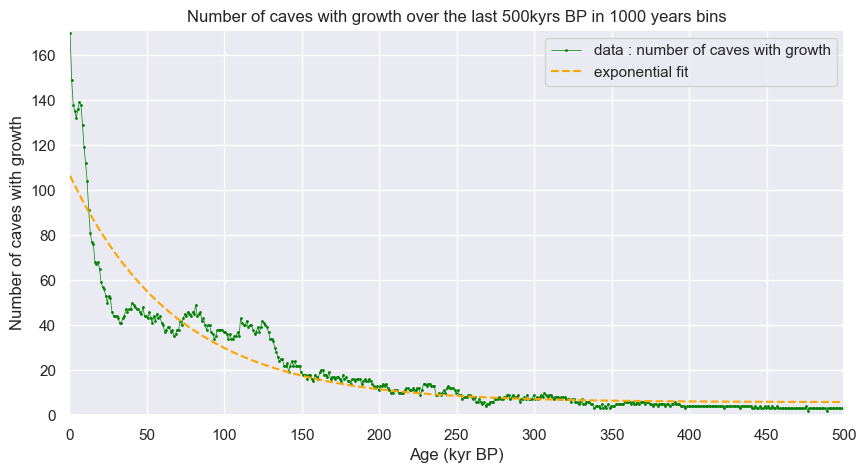

In [16]:
# now we can plot the number of caves with growth over the last 500kyrs BP in 1000 years bins.
# we will consider that a cave has growth in a given 1000 years bin if at least one sample in that cave has an age within that bin.
# Then count the number of unique caves (site_id) with growth in each bin.
# And we also want to compute the uncertainty on this number, by considering the age uncertainty associated with each sample
# (interp_age_uncert_neg, interp_age_uncert_pos). We will use the technique of bootstrapping to estimate the uncertainty on the 
# number of caves with growth in each bin. To compute the bootstrapped uncertainty, we will create 1000 realisations 
# of the valid_df dataframe, by randomly sampling the interp_age within the uncertainty range for each sample.
# Then we will compute the number of caves with growth in each bin for each realisation, and finally compute the 
# 5 and 95% quantiles ot the number of caves with growth in each bin across the 1000 realisations.


bins = np.arange(0,500001,1000)
bin_centers = (bins[:-1] + bins[1:]) / 2
caves_with_growth = np.zeros(len(bin_centers))
for i in range(len(bins)-1):
    bin_start = bins[i]
    bin_end = bins[i+1]
    # find caves with samples with ages in the current bin
    caves_with_growth[i] = len(valid_df.loc[(valid_df['interp_age'] >= bin_start) & (valid_df['interp_age'] < bin_end),'site_id'].unique())
# exponential function to fit to the data
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Now, we compute the bootstrapped uncertainety on the number of caves with growth in each bin
# n_realizations = 100
# bootstrapped_caves_with_growth = np.zeros((n_realizations, len(bin_centers)))
# for r in range(n_realizations):
#     # create a new dataframe with randomly sampled ages within the uncertainety range
#     n=len(valid_df)
#     valid_df_with_uncertainties = valid_df.dropna(subset=['interp_age_uncert_neg','interp_age_uncert_pos'])
#     m=len(valid_df_with_uncertainties)
#     k =n-m
#     sampled_ages = valid_df_with_uncertainties['interp_age'] + np.random.uniform(-valid_df_with_uncertainties['interp_age_uncert_neg'], valid_df_with_uncertainties['interp_age_uncert_pos'])
#     sampled_df = valid_df_with_uncertainties.copy()
#     sampled_df['sampled_age'] = sampled_ages
#     for i in range(len(bins)-1):
#         bin_start = bins[i]
#         bin_end = bins[i+1]
#         # find caves with samples with ages in the current bin
#         bootstrapped_caves_with_growth[r, i] = len(sampled_df.loc[(sampled_df['sampled_age'] >= bin_start) & (sampled_df['sampled_age'] < bin_end),'site_id'].unique()) 
# # compute the 5% and 95% quantiles of the boostraped caves :
# caves_with_growth_q95 = np.percentile(bootstrapped_caves_with_growth, 95, axis=0)+k
# caves_with_growth_q5  = np.percentile(bootstrapped_caves_with_growth, 5, axis=0)+k

# fit an exponential decay to the data
popt, pcov = curve_fit(exp_func, bin_centers, caves_with_growth, p0=(10, 1e-5, 1))

# plot the number of caves with growth in each bin as a function of age (mid-point of the bin)
plt.figure(figsize=(10,5))
plt.plot(bin_centers, caves_with_growth, '-o',markersize=1,linewidth=0.5,color='green',label='data : number of caves with growth')
plt.plot(bin_centers, exp_func(bin_centers, *popt), '--', color='orange',label='exponential fit')
# plt.fill_between(bin_centers, caves_with_growth_q5, caves_with_growth_q95, color='green', alpha=0.2, label='bootstrapped uncertainty')
plt.xlabel('Age (kyr BP)')
plt.ylabel('Number of caves with growth')
plt.title('Number of caves with growth over the last 500kyrs BP in 1000 years bins')
# Set x-ticks in kyr
xticks = np.arange(0, 500001, 50000)
plt.xticks(xticks, (xticks // 1000).astype(int))
plt.xlim(0,500000)
plt.ylim(0,max(caves_with_growth)+1)
plt.grid('minor')
plt.legend()
# plt.savefig('../output/number_of_caves_with_growth.png', dpi=300)
plt.show()

In [17]:
# Now, we will plot the same info but separately for tropical latitudes (>30°N or >30°S) and temperate latitudes.
# find sites in tropical and temperate latitudes
tropical_sites = site_df.loc[site_df['latitude'].abs()<30,['site_id','site_name']]
temperate_sites = site_df.loc[site_df['latitude'].abs()>=30,['site_id','site_name']]
# filter valid_df for tropical and temperate sites 
tropical_df = valid_df[valid_df['site_id'].isin(tropical_sites['site_id'])]
temperate_df = valid_df[valid_df['site_id'].isin(temperate_sites['site_id'])]

# check that all sites of valid_df were either in the tropical or temperate df
print('# of tropical sites in valid_df  :',len(tropical_df['site_id'].unique()),',  # of tropical sites overall  : ',len(tropical_sites['site_id'].unique()))
print('# of temperate sites in valid_df :',len(temperate_df['site_id'].unique()),',  # of temperate sites overall : ',len(temperate_sites['site_id'].unique()))
print('# of sites in valid_df : ',len(valid_df['site_id'].unique()),',  # of sites in trop_df + temp_df :',len(tropical_df['site_id'].unique())+len(temperate_df['site_id'].unique()))

# plot the distribution of caves with growth for both df :
bins = np.arange(0,500001,1000)
bin_centers = (bins[:-1] + bins[1:]) / 2
tropical_caves_with_growth = np.zeros(len(bin_centers))
temperate_caves_with_growth = np.zeros(len(bin_centers))
for i in range(len(bins)-1):
    bin_start = bins[i]
    bin_end = bins[i+1]
    # find caves with samples with ages in the current bin
    tropical_caves_with_growth[i]  = len(tropical_df.loc[(tropical_df['interp_age']   >= bin_start) & (tropical_df['interp_age']  < bin_end),'site_id'].unique())
    temperate_caves_with_growth[i] = len(temperate_df.loc[(temperate_df['interp_age'] >= bin_start) & (temperate_df['interp_age'] < bin_end),'site_id'].unique())

# fit exp function 
popt_trop, pcov_trop = curve_fit(exp_func, bin_centers, tropical_caves_with_growth, p0=(10, 1e-5, 1))
popt_temp, pcov_temp = curve_fit(exp_func, bin_centers, temperate_caves_with_growth, p0=(10, 1e-5, 1))



# of tropical sites in valid_df  : 124 ,  # of tropical sites overall  :  137
# of temperate sites in valid_df : 222 ,  # of temperate sites overall :  228
# of sites in valid_df :  346 ,  # of sites in trop_df + temp_df : 346


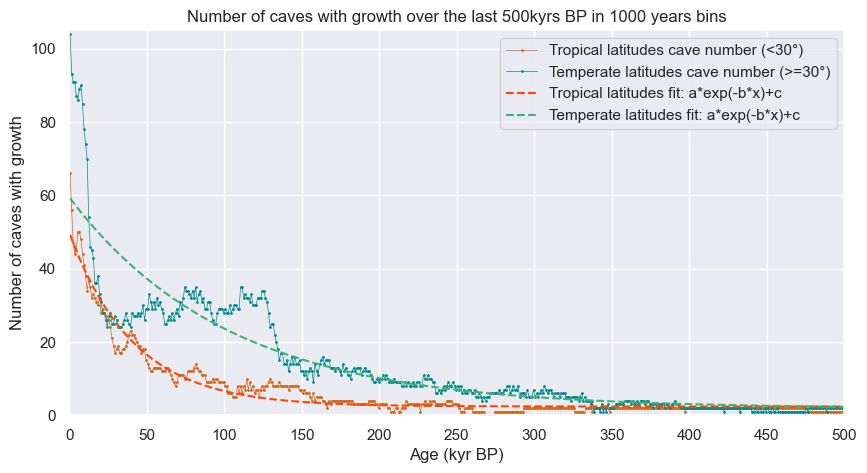

In [18]:
# plot the number of caves with growth in each bin as a function of age (mid-point of the bin)
plt.figure(figsize=(10,5))
plt.plot(bin_centers, tropical_caves_with_growth, '-o',markersize=1 ,linewidth=0.5, label='Tropical latitudes cave number (<30°)', color='chocolate')
plt.plot(bin_centers, temperate_caves_with_growth, '-o',markersize=1,linewidth=0.5, label='Temperate latitudes cave number (>=30°)', color='darkcyan')
plt.plot(bin_centers,exp_func(bin_centers,*popt_trop),'--', label='Tropical latitudes fit: a*exp(-b*x)+c', color='orangered')
plt.plot(bin_centers,exp_func(bin_centers,*popt_temp),'--', label='Temperate latitudes fit: a*exp(-b*x)+c', color='mediumseagreen')
plt.xlabel('Age (kyr BP)')
plt.ylabel('Number of caves with growth')
plt.title('Number of caves with growth over the last 500kyrs BP in 1000 years bins')
# Set x-ticks in kyr
xticks = np.arange(0, 500001, 50000)
plt.xticks(xticks, (xticks // 1000).astype(int))
plt.xlim(0,500000)
plt.ylim(0,max(max(tropical_caves_with_growth),max(temperate_caves_with_growth))+1)
plt.grid('minor')
plt.legend()
# plt.savefig('../output/number_of_caves_with_growth_tropical_temperate.png', dpi=300)
plt.show()

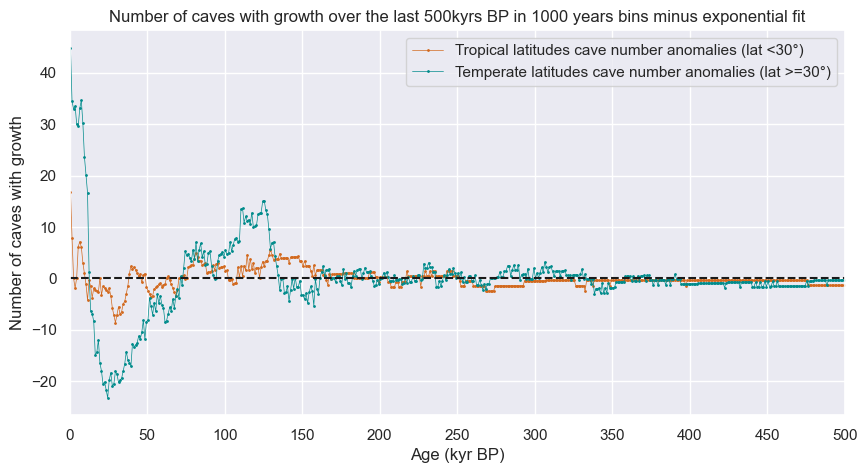

In [19]:
# plot the number of caves with growth in each bin as a function of age (mid-point of the bin)
plt.figure(figsize=(10,5))
plt.plot(bin_centers, tropical_caves_with_growth-exp_func(bin_centers,*popt_trop), '-o',markersize=1 ,linewidth=0.5, label='Tropical latitudes cave number anomalies (lat <30°)', color='chocolate')
plt.plot(bin_centers, temperate_caves_with_growth-exp_func(bin_centers,*popt_temp), '-o',markersize=1,linewidth=0.5, label='Temperate latitudes cave number anomalies (lat >=30°)', color='darkcyan')
plt.hlines(0,0,500000, colors='k', linestyles='--')

# Set x-ticks in kyr
xticks = np.arange(0, 500001, 50000)
plt.xticks(xticks, (xticks // 1000).astype(int))

plt.xlabel('Age (kyr BP)')
plt.ylabel('Number of caves with growth')
plt.title('Number of caves with growth over the last 500kyrs BP in 1000 years bins minus exponential fit')
plt.xlim(0,500000)
plt.grid('minor')
plt.legend()
# plt.savefig('../output/number_of_caves_with_growth_tropical_temperate.png', dpi=300)
plt.show()

#### Geographical distribution of entities over the last 500 kyr

In [20]:
# Define continent for each site
# Africa, Antarctica, Asia, Europe, North America, Oceania, South America, indonesia (transcontinental), Middle East
# This is a very rough definition based on lat and lon limits, so a patchwork of rectangles. A few sites may be missclassed but it should be ok for a first order analysis.

site_df['continent'] = ''
#middle east apart form africa :
site_df.loc[(site_df['latitude']>= -35)&(site_df['latitude']<= 37)&(site_df['longitude']>= -20)&(site_df['longitude']<= 52),'continent']='Africa'
site_df.loc[(site_df['latitude']<= -60),'continent']='Antarctica'
site_df.loc[(site_df['latitude']>= 5)&(site_df['latitude']<= 81)&(site_df['longitude']>= 26)&(site_df['longitude']<= 180),'continent']='Asia'
site_df.loc[(site_df['latitude']>= 35)&(site_df['latitude']<= 72)&(site_df['longitude']>= -25)&(site_df['longitude']<= 50),'continent']='Europe'
site_df.loc[(site_df['latitude']>= 5)&(site_df['latitude']<= 83)&((site_df['longitude']>= -170)&(site_df['longitude']<= -50)),'continent']='North America'
site_df.loc[(site_df['latitude']>= -50)&(site_df['latitude']<= 0)&((site_df['longitude']>= 110)|(site_df['longitude']<= 180)),'continent']='Oceania'
site_df.loc[(site_df['latitude']>= -60)&(site_df['latitude']<= 15)&(site_df['longitude']>= -90)&(site_df['longitude']<= -30),'continent']='South America'
site_df.loc[(site_df['continent']=='') & (site_df['latitude']>= 0) & (site_df['latitude']<= 15) & (site_df['longitude']>= 110) & (site_df['longitude']<= 120),'continent']='Indonesia' # Indonesie, transcontinental
site_df.loc[(site_df['continent']=='') & (site_df['latitude']>= 75) & (site_df['latitude']<= 85) & (site_df['longitude']>= -30) & (site_df['longitude']<= -15),'continent']='North America' # Greenland is on North America plate
site_df.loc[(site_df['latitude']>= 12)&(site_df['latitude']<= 42)&(site_df['longitude']>= 32)&(site_df['longitude']<= 60),'continent']='Middle East' # Middle East

continents = site_df['continent'].unique()
print('Continents found in the site df :',continents)

Continents found in the site df : ['Asia' 'South America' 'Europe' 'Oceania' 'Middle East' 'North America'
 'Indonesia' 'Africa']


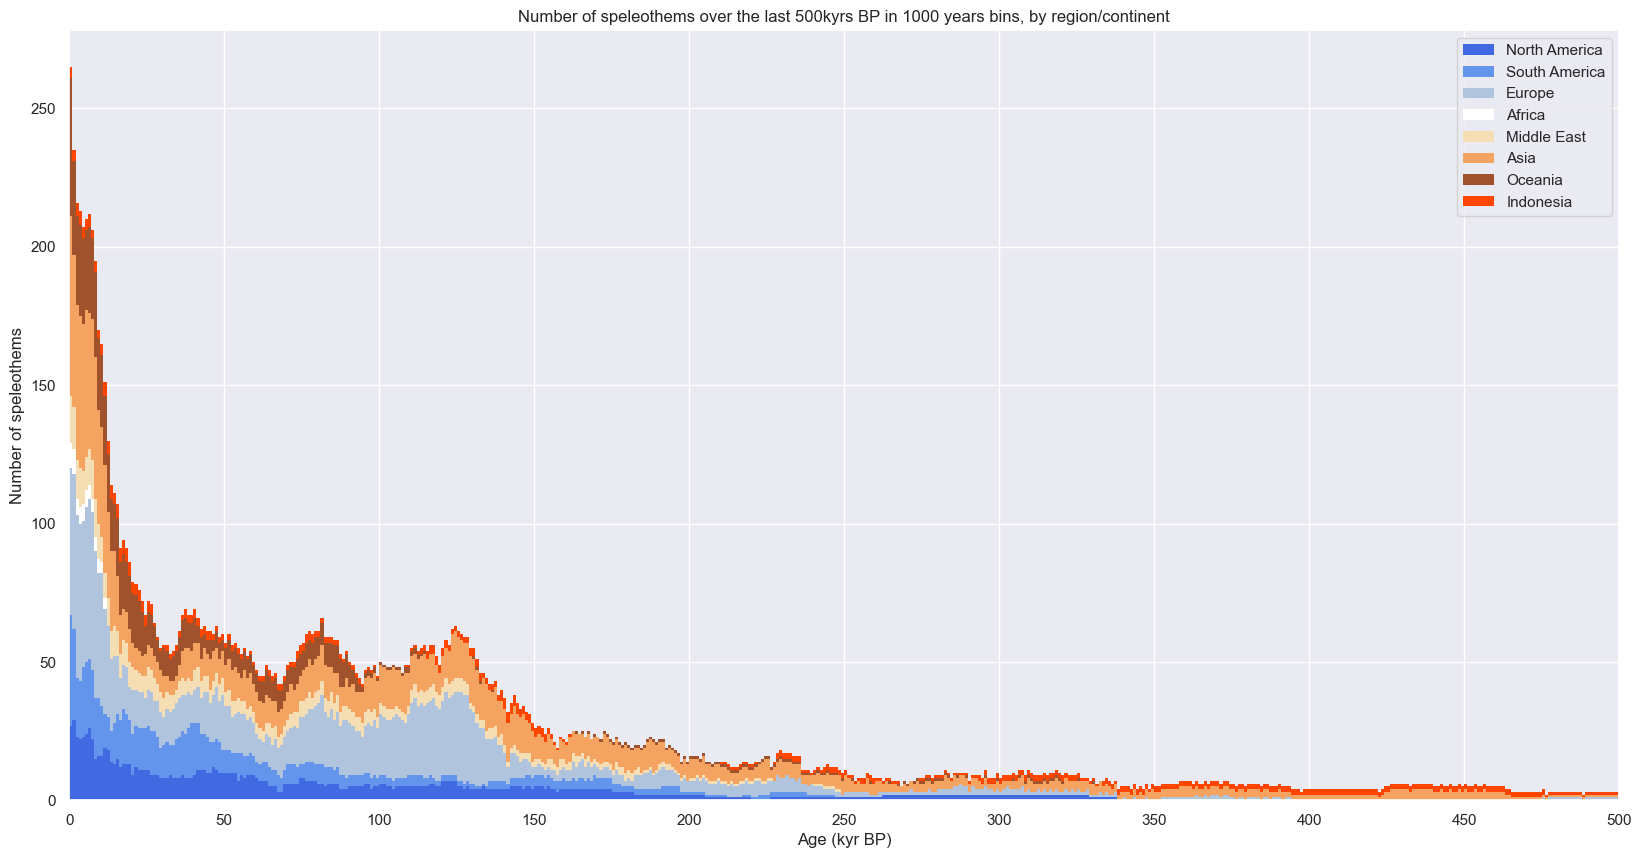

In [21]:
# Now let us plot a histogram of the number of speleothems in bins of 1000 yrs over the last 500kyrs.
# We will also sepparate by continents : Europe, Africa, Asia, North America, South America, Oceania
# We will consider that a speleothem is in a given bin if at least one sample in that speleothem has an age within that bin. If multiple samples in the same speleothem have ages within that bin, we count it only once.

bins = np.arange(0,500001,1000)
bin_centers = (bins[:-1] + bins[1:]) / 2
speleothems_in_bin = np.zeros(len(bin_centers))
speleothems_in_continent_bin = {}
for continent in continents :
    speleothems_in_continent_bin[continent] = np.zeros(len(bin_centers))
    continent_sites = site_df.loc[site_df['continent'] == continent,'site_id']
    continent_df    = valid_df[valid_df['site_id'].isin(continent_sites)]
    for i in range(len(bins)-1):
        bin_start = bins[i]
        bin_end = bins[i+1]
        # find caves with samples with ages in the current bin
        # speleothems_in_bin[i] = len(valid_df.loc[(valid_df['interp_age'] >= bin_start) & (valid_df['interp_age'] < bin_end),'entity_id'].unique())
        # separate by continent
        speleothems_in_continent_bin[continent][i] = len(continent_df.loc[(continent_df['interp_age'] >= bin_start) & (continent_df['interp_age'] < bin_end),'entity_id'].unique())

plt.figure(figsize=(20,10))
# plot from bottom to top : North America, South America, Europe, Africa, Middle East, Asia, Oceania,Indonesia
colors = ['royalblue','cornflowerblue','lightsteelblue','white','wheat','sandybrown','sienna','orangered']
for continent,color in zip(['North America','South America','Europe','Africa','Middle East','Asia','Oceania','Indonesia'],colors):
    if continent in speleothems_in_continent_bin.keys():
        plt.bar(bin_centers, speleothems_in_continent_bin[continent], bottom=speleothems_in_bin, width=1000, label=continent, color=color,edgecolor='none',linewidth=0.5)
        speleothems_in_bin += speleothems_in_continent_bin[continent]

plt.legend()
plt.xlabel('Age (kyr BP)')
plt.ylabel('Number of speleothems')
plt.title('Number of speleothems over the last 500kyrs BP in 1000 years bins, by region/continent')
# Set x-ticks in kyr
xticks = np.arange(0, 500001, 50000)            
plt.xticks(xticks, (xticks // 1000).astype(int))
plt.xlim(0,500000) # change to 22000 to compare to Comas-Bru 2019 fig 1b)
plt.grid('minor')
# plt.savefig('../output/number_of_speleothems.png', dpi=300)
plt.show()

Africa is still under-represented. Europe is still over-represented especially between 70 to 140 kyr BP (last interglacial?)